Sarcasm_Headlines

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
import collections
from wordcloud import WordCloud




[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\benit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_json('Sarcasm_Headlines_Dataset_v2.json', lines=True)
df['headline'][9]
#df.head()

'lots of parents know this scenario'

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB


In [4]:
df.drop_duplicates(inplace=True)
df.isna().any()

is_sarcastic    False
headline        False
article_link    False
dtype: bool

In [5]:
df["is_sarcastic"].value_counts()

0    14984
1    13633
Name: is_sarcastic, dtype: int64

Remove Stopwords

In [6]:
stop = stopwords.words('english')
df['headline'] = df['headline'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)])) #CHTGPT

In [7]:
df['headline'][9]

'lots parents know scenario'

Stemming

In [8]:
ps = PorterStemmer()
df['headline'] = df['headline'].apply(lambda x: ' '.join([ps.stem(word) for word in x.split()]))

Lemmetaization

In [9]:
#Lemmetaization of df['headline']
lemmatizer = WordNetLemmatizer()
df['headline'] = df['headline'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

Data Exploration

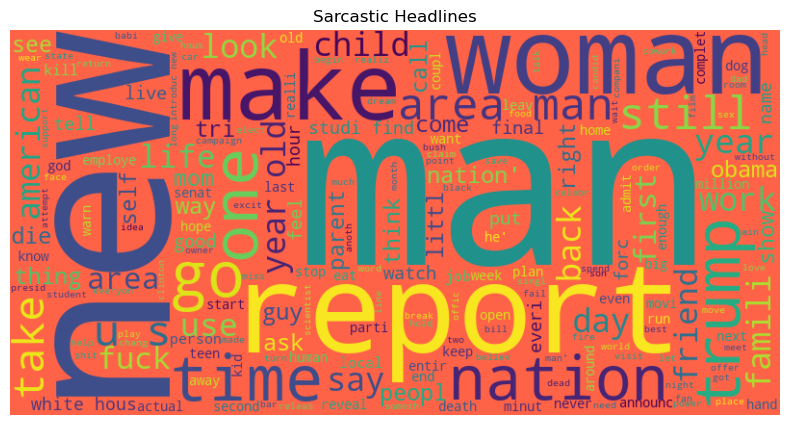

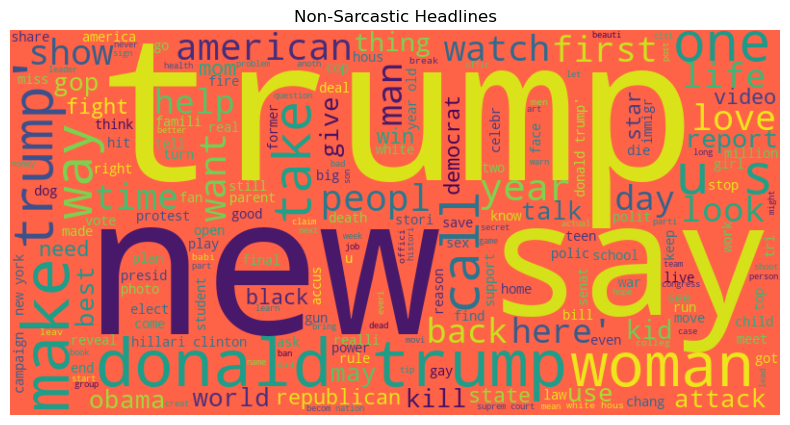

In [10]:
#CHTGPT
df_sarcastic = df[df['is_sarcastic'] == 1]
df_not_sarcastic = df[df['is_sarcastic'] == 0]

# Create a function to generate a word cloud plot
def plot_wordcloud(df_subset, title):
    # Concatenate all the headlines into a single string
    text = " ".join(headline for headline in df_subset['headline'])

    # Generate a word cloud object
    wordcloud = WordCloud(width=800, height=400, max_words=200, background_color="tomato").generate(text)

    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.savefig('plots/'+ title + '.png')
    plt.show()

# Generate the word cloud plot for sarcastic headlines
plot_wordcloud(df_sarcastic, "Sarcastic Headlines")

# Generate the word cloud plot for non-sarcastic headlines
plot_wordcloud(df_not_sarcastic, "Non-Sarcastic Headlines")


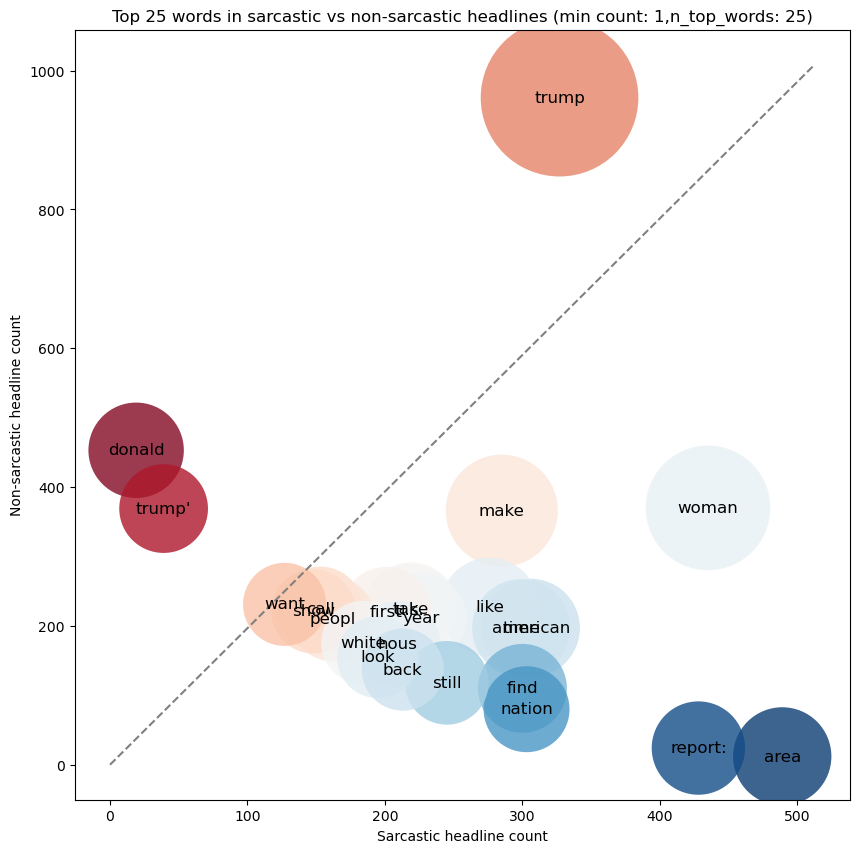

In [11]:
#CHGTPT
min_count = 1
n_top_words = 25

# Count the frequency of each word in sarcastic and non-sarcastic headlines
word_counts = {}
for index, row in df.iterrows():
    for word in row['headline'].split():
        if len(word) > 3:
            if word not in word_counts:
                word_counts[word] = {
                    'count_sarcastic': 0,
                    'count_non_sarcastic': 0,
                    'count_total': 0
                }
            word_counts[word]['count_total'] += 1
            if row['is_sarcastic'] == 1:
                word_counts[word]['count_sarcastic'] += 1
            else:
                word_counts[word]['count_non_sarcastic'] += 1

# Convert the word counts to a DataFrame
df_words = pd.DataFrame.from_dict(word_counts, orient='index')
df_words = df_words[df_words['count_total'] >= min_count]

# Sort the DataFrame by total count
df_words = df_words.sort_values('count_total', ascending=False)

# Select the top n words

df_words = df_words.nlargest(n_top_words, 'count_total')

# Compute the proportion of sarcastic headlines for each word
df_words['prop_sarcastic'] = df_words['count_sarcastic'] / df_words['count_total']

# Define the color map
cmap = cm.get_cmap('RdBu')
colors = cmap(df_words['prop_sarcastic'])

# Create the plot
fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(
    x=df_words['count_sarcastic'], 
    y=df_words['count_non_sarcastic'], 
    s=df_words['count_total']*10,
    alpha=0.8,
    edgecolors='none',
    c=colors
)

# Add a 45-degree line starting from (0,0)
ax.plot([0, ax.get_xlim()[1]], [0, ax.get_ylim()[1]], ls='--', color='gray')

for index, row in df_words.iterrows():
    ax.annotate(row.name, 
                (row['count_sarcastic'], row['count_non_sarcastic']), 
                fontsize=12, 
                ha='center', 
                va='center')

ax.set_xlabel('Sarcastic headline count')
ax.set_ylabel('Non-sarcastic headline count')

ax.set_title(f'Top {n_top_words} words in sarcastic vs non-sarcastic headlines (min count: {min_count},n_top_words: {n_top_words})')

plt.savefig('plots/word_bubbles.png', dpi=300)
plt.show()



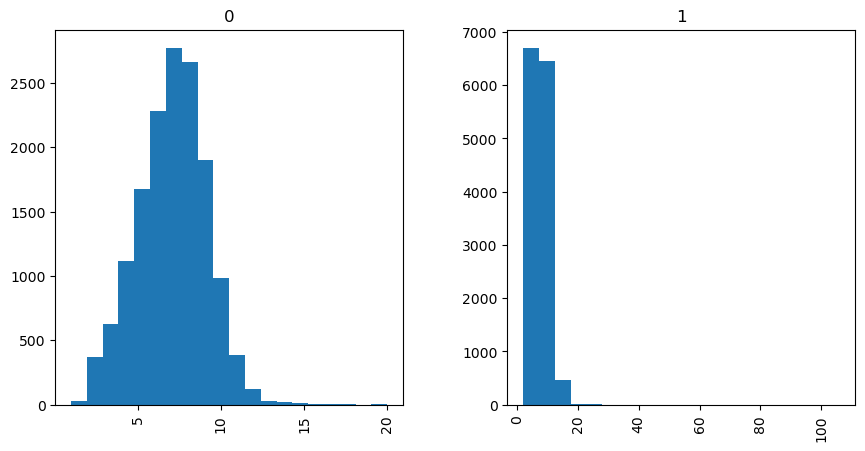

In [12]:
#distribution plot of word counts in df'headline' split by is_sarcastic
df['word_count'] = df['headline'].apply(lambda x: len(x.split()))
df['word_count'].hist(by=df['is_sarcastic'], figsize=(10, 5), bins=20)
plt.savefig('plots/word_count_hist.png', dpi=300)

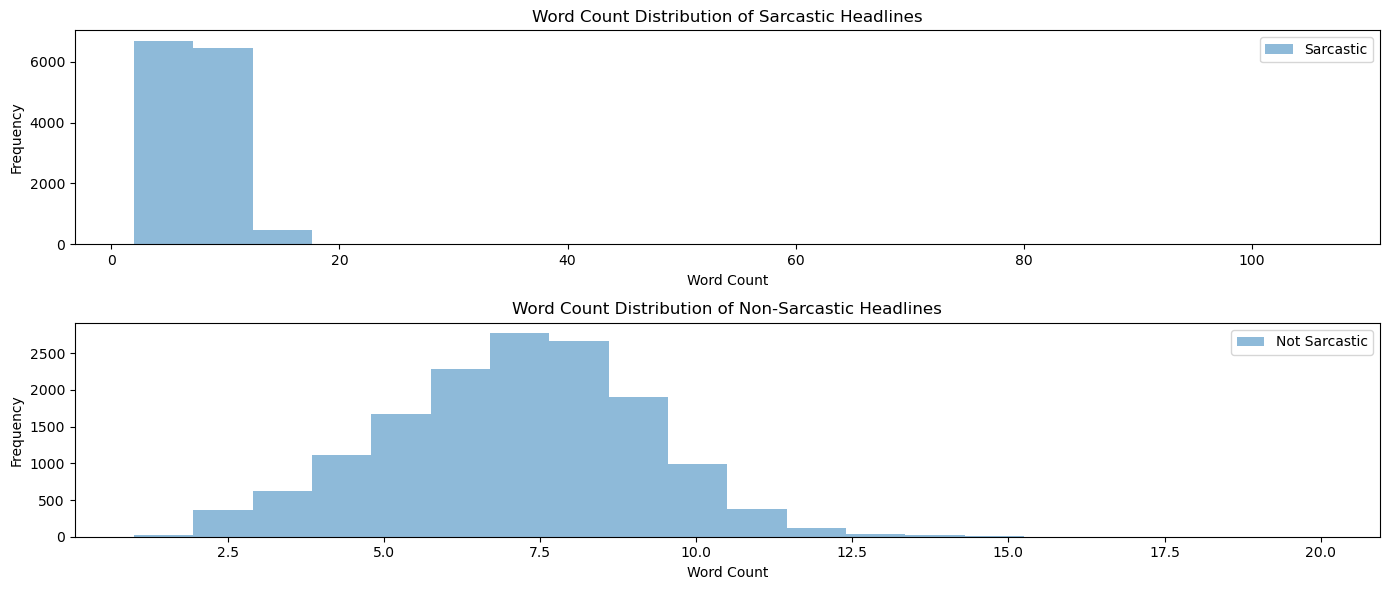

In [13]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(14, 6))
ax[0].hist(df[df['is_sarcastic']==1]['headline'].apply(lambda x: len(x.split())), bins=20, alpha=0.5, label='Sarcastic')
ax[1].hist(df[df['is_sarcastic']==0]['headline'].apply(lambda x: len(x.split())), bins=20, alpha=0.5, label='Not Sarcastic')
ax[0].set_title('Word Count Distribution of Sarcastic Headlines')
ax[1].set_title('Word Count Distribution of Non-Sarcastic Headlines')
ax[0].set_xlabel('Word Count')
ax[1].set_xlabel('Word Count')
ax[0].set_ylabel('Frequency')
ax[1].set_ylabel('Frequency')
ax[0].legend()
ax[1].legend()
plt.tight_layout()
plt.savefig('plots/word_count_hist_1.png', dpi=300)
plt.show()

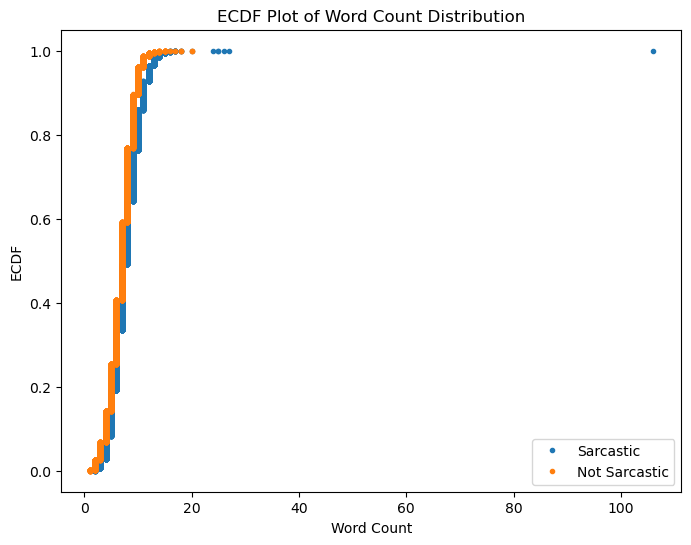

In [14]:
#CHGTPT
sarcasm_wc = df[df['is_sarcastic'] == 1]['headline'].apply(lambda x: len(x.split()))
not_sarcasm_wc = df[df['is_sarcastic'] == 0]['headline'].apply(lambda x: len(x.split()))

fig, ax = plt.subplots(figsize=(8, 6))

x_sarcasm = np.sort(sarcasm_wc)
y_sarcasm = np.arange(1, len(x_sarcasm) + 1) / len(x_sarcasm)
ax.plot(x_sarcasm, y_sarcasm, marker='.', linestyle='none', label='Sarcastic')

x_not_sarcasm = np.sort(not_sarcasm_wc)
y_not_sarcasm = np.arange(1, len(x_not_sarcasm) + 1) / len(x_not_sarcasm)
ax.plot(x_not_sarcasm, y_not_sarcasm, marker='.', linestyle='none', label='Not Sarcastic')

ax.set_xlabel('Word Count')
ax.set_ylabel('ECDF')
ax.set_title('ECDF Plot of Word Count Distribution')
ax.legend()
plt.savefig('plots/ECDF Plot of Word Count Distribution.png', dpi=300)
plt.show()